In [1]:
using Flux
using JLD
using PyPlot
using ScikitLearn.Utils: meshgrid

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
x = dataset.data[:,dataset.labels.==0]
y = dataset.labels;
M, N = size(x)

(2, 90)

In [3]:
# GAN settings
zdim = 1 # code dimension
xdim = M # dimension of data
hiddendim = 32  

# setup the GAN model object
gsize = [zdim; hiddendim; hiddendim; xdim] # generator layout
dsize = [xdim; hiddendim*2; hiddendim*2; 1] # discriminator layout
lambda = 0.5 # anomaly score parameter in [0, 1]
# 1 - ignores the discriminator score
# 0- ignores the reconstruction error score
threshold = 0 # classification threshold, is recomputed (getthreshold or when using fit!)
contamination = size(y[y.==1],1)/size(y, 1) # contamination ratio
L = 30 # batchsize
iterations = 10000 # no of iterations
cbit = 5000 # when should output be printed
verbfit = true # if output should be produced
pz = randn # code distribution (rand should also work)
activation = Flux.leakyrelu # should work better than relu
rdelta = 1e-5 # stop training after this reconstruction error is achieved
# this parameter is basically useless in the case of GANs
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples

model = GANmodel(gsize, dsize, lambda, threshold, contamination, L, iterations, cbit,
    verbfit, pz = pz, activation = activation, rdelta = rdelta, Beta = Beta)

AnomalyDetection.GANmodel(AnomalyDetection.GAN(Chain(Chain(Dense(1, 32, NNlib.leakyrelu), Dense(32, 32, NNlib.leakyrelu)), Dense(32, 2)), Chain(Chain(Dense(1, 32, NNlib.leakyrelu), Dense(32, 32, NNlib.leakyrelu)), Dense(32, 2)), Chain(Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu)), Dense(64, 1, NNlib.σ)), Chain(Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu)), Dense(64, 1, NNlib.σ)), randn), 0.5, 0, 0.1262135922330097, 30, 10000, 5000, true, 1.0e-5, 1.0)

In [4]:
# fit the model
Z = model.gan.pz(zdim,N)
AnomalyDetection.evalloss(model, x, Z)
AnomalyDetection.fit!(model, x)
AnomalyDetection.evalloss(model, x, Z)

discriminator loss: 0.768601
generator loss: 0.695657
reconstruction error: 0.4810850795228727

discriminator loss: 0.609863
generator loss: 0.80048
reconstruction error: 0.09388317130037331

discriminator loss: 0.588285
generator loss: 0.689888
reconstruction error: 0.13082176167563503

discriminator loss: 0.616104
generator loss: 0.660887
reconstruction error: 0.13251442084678494



In [5]:
# generate new data
Xgen = AnomalyDetection.generate(model, N)

2×90 Array{Float64,2}:
 0.803631  0.672373  0.062811  0.597194  …  0.812206  0.60129   0.802126
 0.815466  0.688529  0.94705   0.552588     0.809516  0.550713  0.814994

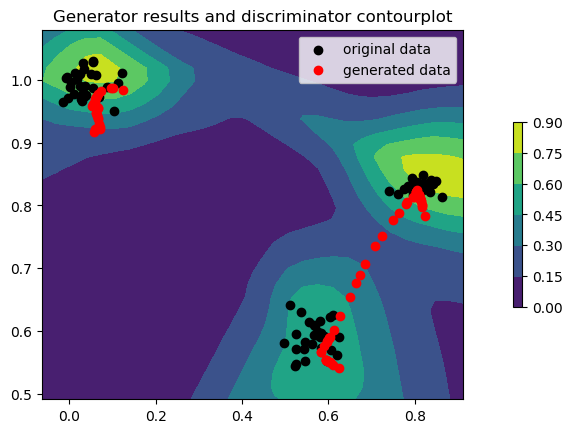

In [6]:
# plot them
figure()
title("Generator results and discriminator contourplot")
scatter(Xgen[1,:], Xgen[2,:]) # first plot jsut to get axis limits
ax = gca()
#ylim = ax[:get_ylim]()
#xlim = ax[:get_xlim]()
xlim = (min(minimum(x[1,:]), minimum(Xgen[1,:])) - 0.05, 
    max(maximum(x[1,:]), maximum(Xgen[1,:])) + 0.05)
ylim = (min(minimum(x[2,:]), minimum(Xgen[2,:])) - 0.05, 
    max(maximum(x[2,:]), maximum(Xgen[2,:])) + 0.05)
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = model.gan.d([xx[i,j], yy[i,j]]).data[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(x[1,:], x[2,:], c = "k", label = "original data")
scatter(Xgen[1,:], Xgen[2,:], c="r", label = "generated data")
legend()
show()

Classification is based on anomaly score computed as a weighted average of reconstruction error and discriminator score
\begin{equation}
A(x) = (1-\lambda)D(x)+\lambda||x-G(z)||_{2, z \sim p(z)}
\end{equation}

In [7]:
# predict labels
X = dataset.data
y = dataset.labels
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1

In [8]:
# get all the labels
tryhat, tstyhat, _, _ = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 86
  fp = 4
  fn = 1
precision: 0.75
recall: 0.9230769230769231
f1score: 0.8275862068965517
equal error rate: 0.06068376068376069

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 89
  fp = 1
  fn = 1
precision: 0.9230769230769231
recall: 0.9230769230769231
f1score: 0.9230769230769231
equal error rate: 0.04401709401709402


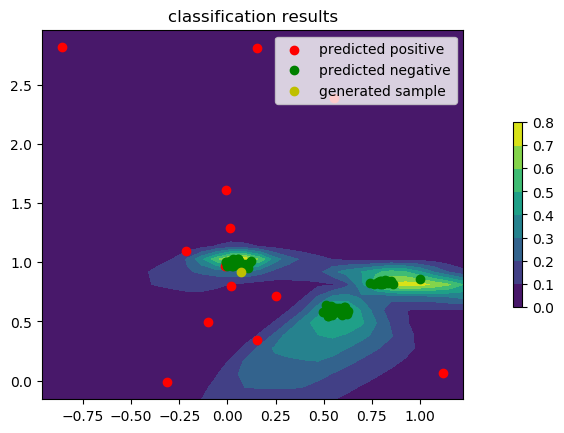

In [9]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
xlim = ax[:get_xlim]()
ylim = ax[:get_ylim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = model.gan.d([xx[i,j], yy[i,j]]).data[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)

scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

In [10]:
# plot EER for different settings of lambda
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate
n = 21
lvec = linspace(0,1,n)
eervec = zeros(n)
for i in 1:n
    model.lambda = lvec[i]
    tryhat, tsthat, trroc, tstroc = AnomalyDetection.rocstats(dataset.data, dataset.labels,
        dataset.data, dataset.labels, model, verb = false)
    eervec[i] = (false_positive_rate(tstroc) + false_negative_rate(tstroc))/2
end

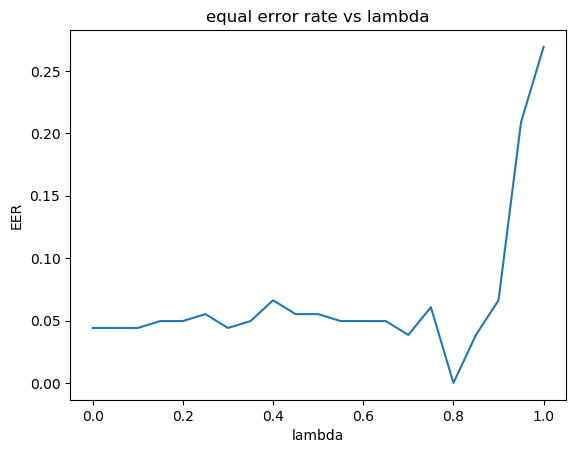

In [11]:
figure()
title("equal error rate vs lambda")
plot(lvec, eervec)
xlabel("lambda")
ylabel("EER")
show()